# 5. Training a network

Now that we know how to create a network, pass an input and an output, we only need to learn how to proceed for training and using it. Let's remember the different steps needed:

In [1]:
from IPython.display import Image

# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

Image(url='https://github.com/guiwitz/DLImaging/raw/master/illustrations/ML_principle.jpg',width=700)

1. First we will pass training examples *forward* through the network
2. We measure an error between prediction and true label, the loss
3. We calculate the gradient of the loss respective to each parameter in the model. This is done by *backpropagation*
4. We adjust the parameters using the calculated gradient and an optimizer (e.g. SGD)

Additionally we will also see in this notebooks additional aspects such as training epochs and validation. The goal here is to once see the whole pipeline in detail before we start using tools that reduce some of the boiler-plate code necessary here.

## Mini-batches

Before we create our network and define a loss, let's remember how training samples are passed through the network. In principle we want to do each optimization step for the **entire dataset** not just a single image as training would have a difficult time to converge. However this is usually not possible and and instead what is generally done is to use **mini-batches**, i.e. the network is iteratively trained on subsets of traininig examples. So now instead of using the gradients produced by a single image, one can use for example the average gradients over the mini-batch:

In [2]:
Image(url='https://github.com/guiwitz/DLImaging/raw/master/illustrations/batch_processing.jpg',width=700) 

PyTorch is in fact designed to handle batches *by default*. We can see that if we look at the documentation of modules such as ```nn.Linear``` which says that inputs should have the shape ```N x ...``` where ```N``` stands for batch size and ```...``` for other dimensions such as channels, samples etc. This applies in fact to all modules, including those calculating losses. We can therefore feed examples with dimensions ```N x ...``` and PyTorch handles batch calculations for us.

## Creating the network

What does this mean for out network? We only have to make one slight modification. We used ```x.view(-1)``` previously to flatten 32x32 images into vectors of 1024 elements. If we now feed a batch of size Nx32x32, this would generate a long vector of size Nx1024. So we need to adjust the ```view()``` command and specify the size of the first dimension. In such a way only the image dimensions are flattened: ```x.view(batchsize, -1)```. Alternatively we can use ```torch.flatten(start_dim = 1)``` specifying from which dimension we want to start flattening:

In [10]:
import torch
from torch import nn
from torch.functional import F

In [11]:
class Mynetwork(nn.Module):
    def __init__(self, input_size, num_categories):
        super(Mynetwork, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(input_size, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, num_categories)

    def forward(self, x):
        
        # flatten the input
        x = x.flatten(start_dim=1)
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        
        return x

And now we instantiate it with:

In [12]:
model = Mynetwork(1024, 2)

Let's check that inputs/outputs work as expected:

In [13]:
myinput = torch.randn((5,32,32))
myinput.size()

torch.Size([5, 32, 32])

In [14]:
myoutput = model(myinput)
myoutput.size()

torch.Size([5, 2])

If we want to pass a single element, e.g. in the inference phase, then we still have to reshape it so that it has dimensions ```N x ...```. The first dimension will just have a size of 1. The simples to do that is to use ```unsqueeze()```:

In [15]:
myimage = torch.randn((32,32))
myimage.size()

torch.Size([32, 32])

In [16]:
myimage = myimage.unsqueeze(0)
myimage.size()

torch.Size([1, 32, 32])

In [17]:
output = model(myimage)
output.size()

torch.Size([1, 2])

## Defining a loss function and and backpropagating

In this example, we are going to classify images. Therefore we can use a standard loss function like cross-entropy which is also available in the ```torch.nn``` module:

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
type(criterion)

torch.nn.modules.loss.CrossEntropyLoss

We see that the loss function is also a module i.e. it is differentiable and can just be integrated in the network. Also it sticks to the same "batch-logic" as the other layers. Therefore it expects inputs whose dimensions start with ```N``` for bactches. What we need here is the output of the network of size ```N x C``` where C is the number of categories (2 in our example) and a list of target labels ("true" labels) which have of course to be turned into a tensor.

We make up some data here:

In [20]:
mysample = torch.randn(3, 32*32)
mylabels = torch.tensor([0,1,1])

We pass them through the network:

In [21]:
output = model(mysample)

And compare output to target with the cross-entropy module:

In [22]:
loss = criterion(output, mylabels)

Note that the ```CrossEntropyLoss``` module **automatically** applies soft-max to the output and then calculates the loss. So we **don't need** to have a soft-max layer at the end of our network.

Now that we have done the forward pass, we can calculate the gradients of the loss by backpropagation. This is simply done by calling the ```backward``` method:

In [23]:
loss.backward()

### Optimizer

Now that we have an estimate of the loss and gradients, we can optimize all our paramters by using some optimization algorithm. Several are available in ```torch.optim```. We use here the Adam optimizer, one of the "safest" choices. As arguments we need to pass a list of parameters that need to be optimized. We can do that by recovering them from our model:

In [24]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0274,  0.0152,  0.0056,  ..., -0.0029,  0.0126,  0.0256],
         [-0.0014,  0.0168, -0.0170,  ..., -0.0104,  0.0176, -0.0168],
         [-0.0101, -0.0104, -0.0165,  ...,  0.0123,  0.0062, -0.0237],
         ...,
         [-0.0039, -0.0304,  0.0112,  ...,  0.0303,  0.0042,  0.0226],
         [ 0.0288, -0.0225,  0.0234,  ..., -0.0166, -0.0284,  0.0128],
         [-0.0017,  0.0139,  0.0117,  ...,  0.0201,  0.0247, -0.0070]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0122, -0.0055,  0.0247, -0.0007, -0.0065, -0.0270,  0.0085, -0.0277,
          0.0213, -0.0139,  0.0052,  0.0030,  0.0101, -0.0065,  0.0134, -0.0265,
          0.0262,  0.0109,  0.0175,  0.0157, -0.0265,  0.0153, -0.0070, -0.0234,
         -0.0052,  0.0140,  0.0044, -0.0039, -0.0069, -0.0009, -0.0136,  0.0031,
         -0.0176, -0.0272, -0.0048,  0.0108,  0.0142, -0.0071,  0.0255, -0.0142,
          0.0133,  0.0146,  0.0105, -0.0095,  0.0312,  0.0179, -0.0124, -0.0202

In [25]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

Now we have to acutally do one step of optimization using the ```step``` method:

In [26]:
optimizer.step()

Let's check that some parameters have really changed:

In [27]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0264,  0.0162,  0.0046,  ..., -0.0039,  0.0116,  0.0246],
         [-0.0024,  0.0158, -0.0160,  ..., -0.0114,  0.0166, -0.0158],
         [-0.0111, -0.0114, -0.0155,  ...,  0.0113,  0.0072, -0.0227],
         ...,
         [-0.0049, -0.0314,  0.0122,  ...,  0.0313,  0.0052,  0.0236],
         [ 0.0298, -0.0215,  0.0224,  ..., -0.0156, -0.0274,  0.0118],
         [-0.0007,  0.0149,  0.0107,  ...,  0.0211,  0.0257, -0.0080]],
        requires_grad=True),
 Parameter containing:
 tensor([-1.1247e-02, -6.5313e-03,  2.3699e-02, -1.6781e-03, -7.4892e-03,
         -2.7992e-02,  7.4765e-03, -2.8675e-02,  2.0316e-02, -1.2889e-02,
          4.2284e-03,  2.0494e-03,  1.1066e-02, -5.4544e-03,  1.2351e-02,
         -2.5544e-02,  2.6171e-02,  9.9048e-03,  1.8486e-02,  1.4749e-02,
         -2.7507e-02,  1.6282e-02, -8.0221e-03, -2.4417e-02, -6.1554e-03,
          1.4993e-02,  3.3583e-03, -2.8540e-03, -5.9054e-03,  9.4057e-05,
         -1.2622e-02,  2.0653e-03, -1.66

## Measuring accuracy

We use the cross-entropy as loss because it allows us to optimize our network. However what we are ultimately interested in is the **accuracy** of our model i.e. whether the correct label has been found or not. Such a binary answer is not useful for optimization but is what we want to monitor in the end. Let's generate some random data and see how we can calculate this:

In [28]:
myimages = torch.randn((3,32,32))
labels = torch.randint(0,2,(3,))

In [29]:
labels

tensor([0, 1, 0])

In [30]:
output = model(myimages)
output

tensor([[-0.0445,  0.0200],
        [ 0.0951, -0.0048],
        [ 0.0114, -0.0642]], grad_fn=<AddmmBackward>)

The predicted category is the one with the highest probability (not normalized here but it doesn't matter). We can therefore just look for the index of the maximum value along the horizontal dimension:

In [31]:
output.argmax(dim=1)

tensor([1, 0, 0])

Now we can compare prediction and true label:

In [32]:
labels == output.argmax(dim=1)

tensor([False, False,  True])

If we take the sum over this tensor, it tells us how many samples in the batch were correctly predicted and the average accuracy is:

In [33]:
(labels == output.argmax(dim=1)).sum()/3

tensor(0.3333)

## Dataset

Now that we know that all steps work, we want to test our network. We will create a synthetic dataset for that using ```skimage.draw```. We will just generate random images with either circles or triangles. As we have an "infinite" amount of data available, we just artificially set a size for our dataset.

Don't forget that we need a training and a validation dataset. Every time we have trained the network with the whole training dataset we check prediction quality with the validation dataset to make sure e.g. we are not over-fitting.

In [34]:
from skimage.draw import random_shapes
import matplotlib.pyplot as plt
import numpy as np

The following function takes as input a keyword - ```triangle```, ```circle```, etc. - and outputs an image with that object as a PyTorch tensor:

In [75]:
def make_image(shape, imsize):
    """Generate image of given shape scaled 0-1.
    shape: str
        shape to draw (circle, triangle, rectangle)
    imsize: int
        size of image
    """
    
    image, _ = random_shapes((imsize,imsize),max_shapes=1, min_shapes=1, multichannel=False, shape=shape,
                                min_size=8)
    #normalize
    image = (255-image)/255

    # turn into tensor
    image_tensor = torch.tensor(image,dtype=torch.float32)
    
    return image_tensor

To create pairs of images and labels we simply create a list of possible shapes and randomly pick values from there. We should also not forget to transform the label into a tensor. Let's make a single image:

In [76]:
im_type = ['circle', 'triangle','rectangle']
num_cat = len(im_type)
image_size = 32

label = torch.randint(0,num_cat,(1,))
image = make_image(im_type[label], image_size)

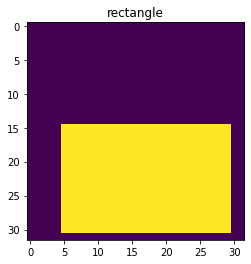

In [77]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title(im_type[label]);

We want to train our network using mini-batches, and each batch should have a size ```N x H x W``` where ```N``` is the batch size and ```H,W``` the image dimension. We can create a batch by stacking multiple 2D tensors together:

In [78]:
batch_size = 10
single_batch = torch.stack([make_image('circle', image_size) for x in range(batch_size)])
single_batch.size()

torch.Size([10, 32, 32])

Of course we want to mix the different image types, so we generate labels of size ```batch_size``` as well:

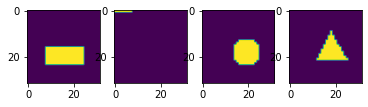

In [79]:
label = torch.randint(0,num_cat,(batch_size,))
single_batch = torch.stack([make_image(im_type[x], image_size) for x in label])

fig, ax = plt.subplots(1,4)
for x in range(4):
    ax[x].imshow(single_batch[x,:,:])

Finally we can create our full dataset (as a list of tensors) by generating ```M``` bachtes in order to have ```M x N``` training examples:

In [80]:
# size of training dataset
batch_size = 10
training_size = 5000
validation_size = 100
train_batch_number = int(training_size/batch_size)
validation_batch_number = int(validation_size/batch_size)

training_label = [torch.randint(0,num_cat,(batch_size,)) for i in range(train_batch_number)]
validation_label = [torch.randint(0,num_cat,(batch_size,)) for i in range(validation_batch_number)]

train_batches = [torch.stack([make_image(im_type[x], image_size) for x in lab]) for lab in training_label]
valid_batches = [torch.stack([make_image(im_type[x], image_size) for x in lab]) for lab in validation_label]


## Training loop

Now we can create a loop where we iterate through our batches to train our network and go through the steps defined above. We will do two loops: 
1. Over epochs: one epoch representing a training step over **all batches**
2. Over batches

We do validation only once per epoch to see how training goes.

In [65]:
#del model
model = Mynetwork(1024, 3)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2):
    
    print(f'epoch: {epoch}')
    
    # initialize running accuracy
    running_accuracy = 0
    
    for t in range(train_batch_number):
    
        # get batch
        label = training_label[t]
        mybatch = train_batches[t]

        # calculate predicted label and calculate loss
        pred = model(mybatch)
        loss = criterion(pred, label)

        # backpropagate the loss
        loss.backward()

        # do the optimization step
        optimizer.step()

        # set gradients to zero as PyTorch accumulates them otherwise
        optimizer.zero_grad()

        # calculate accuracy
        mean_accuracy = (torch.argmax(pred,dim=1) == label).sum()/batch_size
        running_accuracy+=mean_accuracy

        every_nth = 1000
        if t % every_nth == every_nth-1: 
            print(f'accuracy: {running_accuracy/every_nth}')
            running_accuracy = 0.0
    
    # validation
    valid_accuracy = 0
    for t in range(validation_batch_number):
    
        # get batch
        label = validation_label[t]
        mybatch = valid_batches[t]

        # calculate predicted label
        pred = model(mybatch)
        # calculate accuracy
        mean_accuracy = (torch.argmax(pred,dim=1) == label).sum()/batch_size
        valid_accuracy += mean_accuracy
    valid_accuracy = valid_accuracy/validation_batch_number
    print(f'valid_accuracy: {valid_accuracy}')

epoch: 0
valid_accuracy: 0.7200000286102295
epoch: 1
valid_accuracy: 0.7599999308586121


We see that accuracy improves but not to a perfect level. We can try to increase the number of epochs or the training size. We can also try to understand where the problem is. For example we can try to find out which images are most mis-classified using a confusion matrix from scikit-learn.

In [66]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

We generate a test batch and obtain a prediction with our model:

In [81]:
label = torch.randint(0,len(im_type),(100,))
mybatch = torch.stack([make_image(im_type[x], image_size) for x in label])
pred = model(mybatch)

Again the maximum index for each element of the batch gives us the final class:

In [68]:
pred.argmax(dim=1)

tensor([1, 0, 1, 1, 1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1,
        2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 1, 1, 1, 2, 1, 1, 0, 2, 2, 1,
        0, 1, 2, 1, 2, 0, 0, 1, 0, 2, 1, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2, 2, 1,
        1, 2, 1, 2, 1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 1, 0,
        1, 1, 0, 2])

In [69]:
label

tensor([0, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1,
        2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 1,
        0, 1, 2, 0, 2, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 2, 2, 1,
        0, 0, 1, 0, 0, 2, 1, 2, 2, 0, 2, 1, 1, 1, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0,
        1, 1, 0, 2])

Let's calcualte the confusion matrix and transform it into a Dataframe that we can then easily plot with seaborn:

In [70]:
df_cm = pd.DataFrame(confusion_matrix(pred.argmax(dim=1), label), index = im_type,
                  columns = im_type)

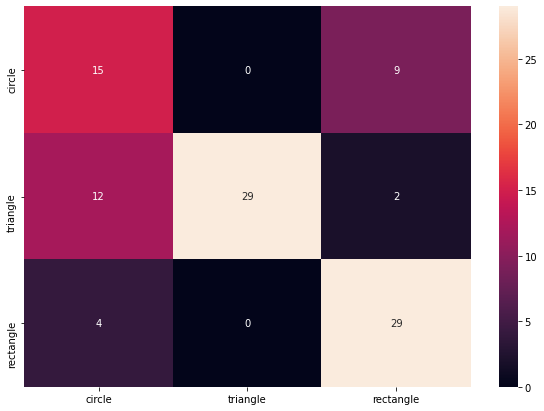

In [71]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True);

We see that the problem is mostly the circle. Because we use a tiny image, small circles are not smooth and can look like rectangles or triangles.

## Exercises

1. Re-use the network you have create for the exercise 4. Make sure it can take **batches** of 2D images as input.
2. Create an image generator which creates black (value=0) images (2D tensors) with a single white (value=1) line which is vertical (class #1) or horizontal (class #2)
3. Create training and validation data generators
4. Add a training loop and train. Verify that the nework works
5. "Bonus": try to add various levels of noise to the image and see how prediction is affected